# Importing Necessary Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import keras
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding, Dense, Dropout, MaxPooling1D, Conv1D, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, matthews_corrcoef
%matplotlib inline

# Loading Data

In [3]:
df = pd.read_csv("CVAssignmentDataset.csv")

In [4]:
df.head(5)

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...


In [5]:
df["Text"][0]

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L'

In [6]:
df.shape

(86461, 2)

# Data Preprocessing

In [7]:
## Checking for NULL value

df.isnull().sum()

Class    0
Text     1
dtype: int64

In [8]:
df.dropna(axis=0,inplace=True)

In [9]:
# Stopwords for english language

stopwords = stopwords.words('english')
stopwords.append("rt")
stopwords.append("u")
stopwords.append("amp")
stopwords.append("w")
stopwords.append("th")

In [10]:
# Cleaning Text Column

sent_list = []

for d in df["Text"]:
    
    d = re.sub(r'http\S+', '', d) # remove links
    
    d = re.sub("[^a-zA-Z]", " ", d) # remove all characters except letters
    
    d = d.lower() # convert all words to lowercase
    
    d = nltk.word_tokenize(d) # split sentences into word
    
    d = [word for word in d if not word in set(stopwords)] # add to stopwords list if unnecessary words.
    
    lemma = WordNetLemmatizer() 
    d=[lemma.lemmatize(word) for word in d] # converting similar meaning words to same meaningful word.
    
    d=" ".join(d)
    
    sent_list.append(d) #append words to list

In [11]:
sent_list[:5]

['today senate dems vote savetheinternet proud support similar netneutrality legislation house',
 'winterhavensun winter resident alta vista teacher one several recognized repdarrensoto national teacher apprecia',
 'nbclatino repdarrensoto noted hurricane maria left approximately billion damage congress allocated',
 'nalcabpolicy meeting repdarrensoto thanks taking time meet latinoleader ed marucci guzman nalcabpolicy',
 'vegalteno hurricane season start june st puerto rico readiness well pwr puertorico repdarrensoto espaillatny']

In [12]:
## Frequency of words

Text_Freq = str(sent_list).split()

Text_Freq = [word.replace("'","") for word in Text_Freq ]
Text_Freq = [word.replace("[", "") for word in Text_Freq ]
Text_Freq = [word.replace("]","") for word in Text_Freq ]
Text_Freq = [word.replace(",", "") for word in Text_Freq ]

In [13]:
print("Word length : ",len(Text_Freq))

Word length :  900431


In [14]:
fdist_text = FreqDist(Text_Freq)

In [15]:
fdist_text

FreqDist({'today': 8733, 'great': 4552, 'american': 4294, 'tax': 4112, 'thank': 3895, 'house': 3894, 'bill': 3822, 'year': 3796, 'day': 3458, 'family': 3210, ...})

In [16]:
# Top 10k words ordered by frequency

from operator import itemgetter
Text_Words = sorted(fdist_text.items(), key=itemgetter(1), reverse=True)
Text_Words = [list(i) for i in Text_Words]
High_Freq_Words=[]
for i in Text_Words:
    High_Freq_Words.append(i[0])

In [17]:
len(High_Freq_Words)
High_Freq_Words = High_Freq_Words[0:10000]

In [18]:
High_Freq_Words[0:10]

['today',
 'great',
 'american',
 'tax',
 'thank',
 'house',
 'bill',
 'year',
 'day',
 'family']

Now, we will move forward to building model as per architecture provided in the dataset

# Model Building

In [19]:
# sent_list
top_words = 10000  # We'll keep these many distinct tokens and drop less frequent ones
one_hot_repr = [ one_hot(word,top_words) for word in sent_list ]
max_sent_length = 50

In [20]:
enbedded_docs = pad_sequences(one_hot_repr,padding='pre',maxlen=max_sent_length)

In [21]:
X_final = np.array(enbedded_docs)
y_final = np.array(df["Class"]).astype(int)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final,test_size=0.3,random_state=42)

In [89]:
# create the model

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_sent_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Dropout(rate=0.87))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(rate=0.87))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.87))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.87))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_test,y_test))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 32)            320000    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 25, 512)           591872    
_________________________________________________________________
dropout_68 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 512)               1574912   
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)             

In [90]:
preds = np.round(model.predict(X_test).ravel())

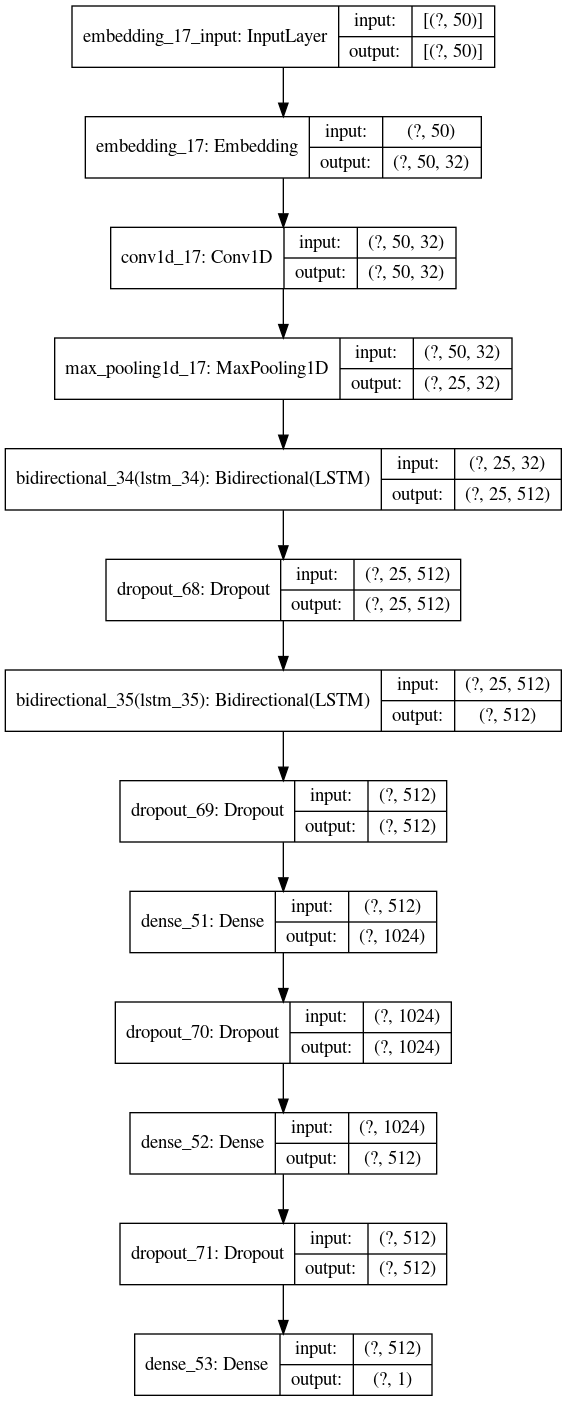

In [91]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
)

# Accuracy

In [92]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7479


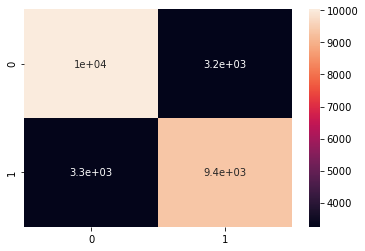

In [93]:
sns.heatmap(confusion_matrix(y_test,preds),annot=True)

In [94]:
print('Accuracy: {}'.format(str(round(matthews_corrcoef(y_test, preds), 4))))

Accuracy: 0.4955


We can improve score by performing hyperparameter optimization but since it is not mentioned in task 1, we are not going to perform it.

# Thank You